In [21]:
import torch
import numpy as np
from utils.generate_csbm import *
from utils.train_helpers import *
from utils import generate_csbm
from models.models import *
from models.setup import *
import networkx as nx
import pickle

In [22]:
train_ids = np.load("experiments/DNC/0.78phi/data/train_ids.npy")
val_ids = np.load("experiments/DNC/0.78phi/data/valid_ids.npy")
test_ids = np.load("experiments//DNC/0.78phi/data/test_ids.npy")

for ith in range(20):
    csbm.generate_node_data(method="SNC", n_local=40)
    file_to_store = open("experiments/SNC/0.78phi/data/"+"csbm_"+str(ith)+".pickle", "wb")
    pickle.dump(csbm, file_to_store)
    file_to_store.close()

In [23]:
def exp_csbm(ith, method, folder_path, csbm, train_ids, val_ids, test_ids, 
             num_communication=100, batch_size=1,
             learning_rate=0.2, I=10, gradient=True, noise=False,
             Print=False, print_time=1,
             resume=False,
             bias=False,
             save=True):
    

    init_mlp = MLP(csbm.Xs[0].shape[1], 64, 2, bias)
        
    if (gradient == False):
        grad = "no_grad/"
    elif (gradient == True and noise==False):
        grad = "biased_grad/"
    elif (gradient == True and noise==True):
        grad = "noisy_grad/"
      
    A_tilde = calculate_Atilde(csbm.A, K=10, alpha=0.9)
    server = set_up_NC(csbm.Xs, csbm.ys, init_mlp, A_tilde, train_ids, val_ids, test_ids)
   
        
    tl, ta, vl, va = train_NC(server, num_communication, batch_size, learning_rate, I,
                              gradient, noise, 
                              Print, print_time)
    print (server.eval_test()[1])
    if save:    
        np.save(folder_path + method + grad + "I" + str(I) + "/tl_" + str(ith), tl)
        np.save(folder_path + method + grad + "I" + str(I) + "/ta_" + str(ith), ta)
        np.save(folder_path + method + grad + "I" + str(I) + "/vl_" + str(ith), vl)
        np.save(folder_path + method + grad + "I" + str(I) + "/va_" + str(ith), va)

        PATH = folder_path + method + grad + "I" + str(I) + "/model_" + str(ith)
        torch.save({
                'best_model_state_dict': server.best_cmodel.state_dict(),
                'learning_rate': learning_rate,
                'test_acc': server.eval_test()[1],
                'model_state_dict': server.cmodel.state_dict(),
                'best_valloss': server.best_valloss,
                'best_valacc': server.best_valacc,
                }, PATH)

In [33]:
for ith in range(20):
    I=10
    file_to_open= open("experiments/DNC/0.78phi/data/"+"csbm_"+str(ith)+".pickle", "rb")
    csbm = pickle.load(file_to_open)
    file_to_open.close()
    nc = int(1000/I)
    init_mlp = MLP(csbm.Xs[0].shape[1], 64, 2, bias)
    A_tilde = calculate_Atilde(csbm.A, K=10, alpha=0.9)
    server = set_up_NC(csbm.Xs, csbm.ys, init_mlp, A_tilde, train_ids, val_ids, test_ids)
    tl, ta, vl, va = train_NC(server, nc, 1, 0.2, I, True, 5)
    print (ith, I)

ModuleNotFoundError: No module named 'generate_csbm'

In [25]:
init_mlp = MLP(csbm.Xs[0].shape[1], 64, 2, bias)

A_tilde = calculate_Atilde(csbm.A, K=10, alpha=0.9)
server = set_up_NC(csbm.Xs, csbm.ys, init_mlp, A_tilde, train_ids, val_ids, test_ids)


tl, ta, vl, va = train_NC(server, num_communication, batch_size, learning_rate, I,
                          gradient, noise, 
                          Print, print_time)

NameError: name 'csbm' is not defined

In [7]:
torch.load("experiments/SNC/0.78phi/result/NC/biased_grad/I50/model_10",
            map_location=torch.device('cpu'))["test_acc"]

FileNotFoundError: [Errno 2] No such file or directory: 'experiments/SNC/0.78phi/result/NC/biased_grad/I50/model_10'

In [ ]:
for ith in range(20):
    for I in [10, 20, 50]:
        file_to_open= open("experiments/SNC/0.78phi/data/"+"csbm_"+str(ith)+".pickle", "rb")
        csbm = pickle.load(file_to_open)
        file_to_open.close()
        nc = int(5000/I)
        exp_csbm(ith, "NC/", "experiments/SNC/0.78phi/result/", csbm, train_ids, val_ids, test_ids, 
             num_communication=nc, batch_size=40,
             learning_rate=0.2, I=I, gradient=True, noise=False,
             Print=False, print_time=10,
             resume=False,
             bias=False,
             save=True)
        print (ith, I)

In [8]:
folders = ["experiments/SNC/0.78phi/result/"]
mcora = ["10 no_grad/",  "20 no_grad/",  "50 no_grad/"]
ms = [mcora]
exps = np.arange(20)
testacc_means = []
names = []
testacc_stds = []

for i in range(len(folders)):
    for m in ms[i]:
        I, grad = m.split(" ")
        I = int(I)
        if grad == "no_grad/":
            grad_name = "No Compensation"
        elif grad == "biased_grad/":
            grad_name = "Gradient Compensation"
        elif grad == "noisy_grad/":
            grad_name = "Noisy Gradient Compensation"
        tls, tas, vls, vas, test_accs, steps = read_result(exps, "NC/", folders[i], I, grad)
        print (test_accs)
        testacc_means.append(np.mean(test_accs))
        testacc_stds.append(np.std(test_accs))
        names.append(grad_name+str(I))

NameError: name 'read_result' is not defined

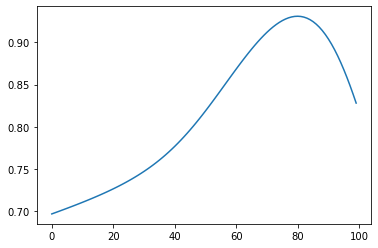

In [83]:
plt.plot(vls[16])

In [93]:
for ith in range(20):
    for I in [50]:
        file_to_open= open("experiments/SNC/0.78phi/data/"+"csbm_"+str(ith)+".pickle", "rb")
        csbm = pickle.load(file_to_open)
        file_to_open.close()
        nc = int(5000/I)
        exp_csbm(ith, "NC/", "experiments/SNC/0.78phi/result/", csbm, train_ids, val_ids, test_ids, 
             num_communication=nc, batch_size=40,
             learning_rate=0.5, I=I, gradient=False, noise=False,
             Print=True, print_time=50,
             resume=False,
             bias=False,
             save=False)
        print (ith, I)

Communication: 1 Average train loss: 0.69160 Average train accuracy: 0.665 Average val loss: 0.69376 Average val accuracy: 0.350
Communication: 51 Average train loss: 0.23445 Average train accuracy: 0.958 Average val loss: 0.43074 Average val accuracy: 0.950
0.99375
0 50
Communication: 1 Average train loss: 0.68604 Average train accuracy: 0.650 Average val loss: 0.70032 Average val accuracy: 0.350
Communication: 51 Average train loss: 0.25718 Average train accuracy: 0.939 Average val loss: 0.48207 Average val accuracy: 0.800
0.96875
1 50
Communication: 1 Average train loss: 0.68811 Average train accuracy: 0.650 Average val loss: 0.69811 Average val accuracy: 0.350
Communication: 51 Average train loss: 0.28327 Average train accuracy: 0.934 Average val loss: 0.50285 Average val accuracy: 0.800
0.95
2 50
Communication: 1 Average train loss: 0.68853 Average train accuracy: 0.650 Average val loss: 0.69706 Average val accuracy: 0.350
Communication: 51 Average train loss: 0.22926 Average trai

In [22]:
for ith in range(20):
    for I in [1]:
        file_to_open= open("experiments/SNC/0.78phi/data/"+"csbm_"+str(ith)+".pickle", "rb")
        csbm = pickle.load(file_to_open)
        file_to_open.close()
        nc = int(5000/I)
        exp_csbm(ith, "NC/", "experiments/SNC/0.78phi/result/", csbm, train_ids, val_ids, test_ids, 
             num_communication=nc, batch_size=40,
             learning_rate=0.2, I=I, gradient=True, noise=False,
             Print=False, print_time=10,
             resume=False,
             bias=False,
             save=True)
        print (ith, I)

0 1
1 1
2 1
3 1
4 1
5 1
6 1
7 1
8 1
9 1
10 1
11 1
12 1
13 1
14 1
15 1
16 1
17 1
18 1
19 1


In [96]:
for ith in range(20):
    for I in [50]:
        file_to_open= open("experiments/SNC/0.78phi/data/"+"csbm_"+str(ith)+".pickle", "rb")
        csbm = pickle.load(file_to_open)
        file_to_open.close()
        nc = int(10000/I)
        exp_csbm(ith, "NC/", "experiments/SNC/0.78phi/result/", csbm, train_ids, val_ids, test_ids, 
             num_communication=nc, batch_size=40,
             learning_rate=0.1, I=I, gradient=True, noise=True,
             Print=False, print_time=10,
             resume=False,
             bias=False,
             save=True)
        print (ith, I)

0.99375
0 50
0.99375
1 50
1.0
2 50
0.9875
3 50
1.0
4 50
0.9875
5 50
0.99375
6 50
0.9875
7 50
0.9875
8 50
0.99375
9 50
0.9875
10 50
0.99375
11 50
0.99375
12 50
0.9875
13 50
0.9875
14 50
0.99375
15 50
0.98125
16 50
0.9875
17 50
0.975
18 50
0.9875
19 50
